<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/XGBoost_Regressor_with_SHAP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES**

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from itertools import product
import statsmodels.api as sm
import shap
from IPython.display import display
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import warnings
warnings.filterwarnings("ignore")

# **XGBOOST REGRESSOR**

## **Feature Engineering**

We first apply Feature Engineering to add rolling window statistic features and time based features on both training and test sets as input features to boost the performance of the model.

In [14]:
# Load train and test datasets
train_df = pd.read_csv("/content/drive/MyDrive/training_set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test_set.csv")

# List of numerical features to process
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
            'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
            'ServingCell_Distance', 'Categorical_Impact']

# Parameters
rolling_features = ['RSRP', 'RSRQ', 'SNR', 'RSSI', 'Speed', 'DL_bitrate', 'UL_bitrate'] # Features for rolling window
rolling_windows = [10, 30]  # Duration of roling window in minutes
apply_log_to = ['DL_bitrate', 'UL_bitrate'] # Features for log transformation

for df in [train_df, test_df]:
    # Convert timestamp to datetime and extract time-based features
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df["Hour"] = df["Timestamp"].dt.hour
    df["Day_of_week"] = df["Timestamp"].dt.dayofweek
    df["Is_weekend"] = df["Day_of_week"].isin([5, 6]).astype(int)

    # Compute rolling mean features
    for feature in rolling_features:
        for window in rolling_windows:
            df[f"{feature}_roll_mean_{window}"] = df[feature].rolling(window=window).mean()

    # Drop rows with NaNs introduced by rolling or lagging
    df.dropna(inplace=True)

    # Apply log1p transformation to selected features
    for col in apply_log_to:
        df[col] = np.log1p(df[col])

In [15]:
train_df

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,...,SNR_roll_mean_10,SNR_roll_mean_30,RSSI_roll_mean_10,RSSI_roll_mean_30,Speed_roll_mean_10,Speed_roll_mean_30,DL_bitrate_roll_mean_10,DL_bitrate_roll_mean_30,UL_bitrate_roll_mean_10,UL_bitrate_roll_mean_30
29,2017-11-21 15:04:20,0.0,-100.0,-14.0,1.0,6.0,-84.0,6.705639,2.944439,-103.4,...,-1.3,0.900000,-83.6,-82.900000,0.0,0.100000,594.2,640.133333,16.5,20.900000
30,2017-11-21 15:04:21,0.0,-100.0,-14.0,1.0,6.0,-87.0,6.705639,2.995732,-103.8,...,-0.8,0.800000,-83.8,-83.133333,0.0,0.100000,613.2,667.333333,17.0,21.533333
31,2017-11-21 15:04:22,3.0,-100.0,-14.0,1.0,6.0,-87.0,6.705639,2.995732,-104.2,...,-0.2,0.766667,-84.2,-83.433333,0.3,0.200000,625.5,694.533333,17.6,22.166667
32,2017-11-21 15:04:22,3.0,-103.0,-13.0,1.0,6.0,-87.0,6.771936,2.995732,-104.6,...,0.4,0.366667,-84.6,-83.666667,0.6,0.300000,615.4,723.600000,16.8,22.800000
33,2017-11-21 15:04:23,3.0,-103.0,-13.0,1.0,6.0,-87.0,6.052089,2.890372,-105.0,...,0.4,-0.033333,-85.3,-83.900000,0.9,0.366667,615.4,737.733333,17.1,23.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0.0,-95.0,-14.0,-5.0,8.0,-88.0,8.826441,4.644391,-98.0,...,-4.3,-4.133333,-88.0,-87.150000,18.4,23.000000,10105.6,9684.233333,155.4,159.666667
138949,2018-01-18 15:03:26,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.570669,5.379897,-107.0,...,-4.1,-4.033333,-88.0,-87.150000,23.0,23.000000,10995.8,9843.766667,168.1,161.866667
138950,2018-01-18 15:03:27,0.0,-95.0,-14.0,-5.0,8.0,-88.0,9.041211,4.962845,-98.0,...,-4.3,-4.033333,-88.0,-87.450000,18.4,23.000000,10663.6,9942.933333,165.4,163.733333
138951,2018-01-18 15:03:28,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.640758,5.549076,-107.0,...,-3.9,-3.933333,-88.0,-87.450000,23.0,23.000000,11593.0,9995.133333,178.6,164.933333


Then, we plot the ACF for every numeric feature of the training set to determine the amount of lags needed and the interval between them, since the granularity is 1 sec.

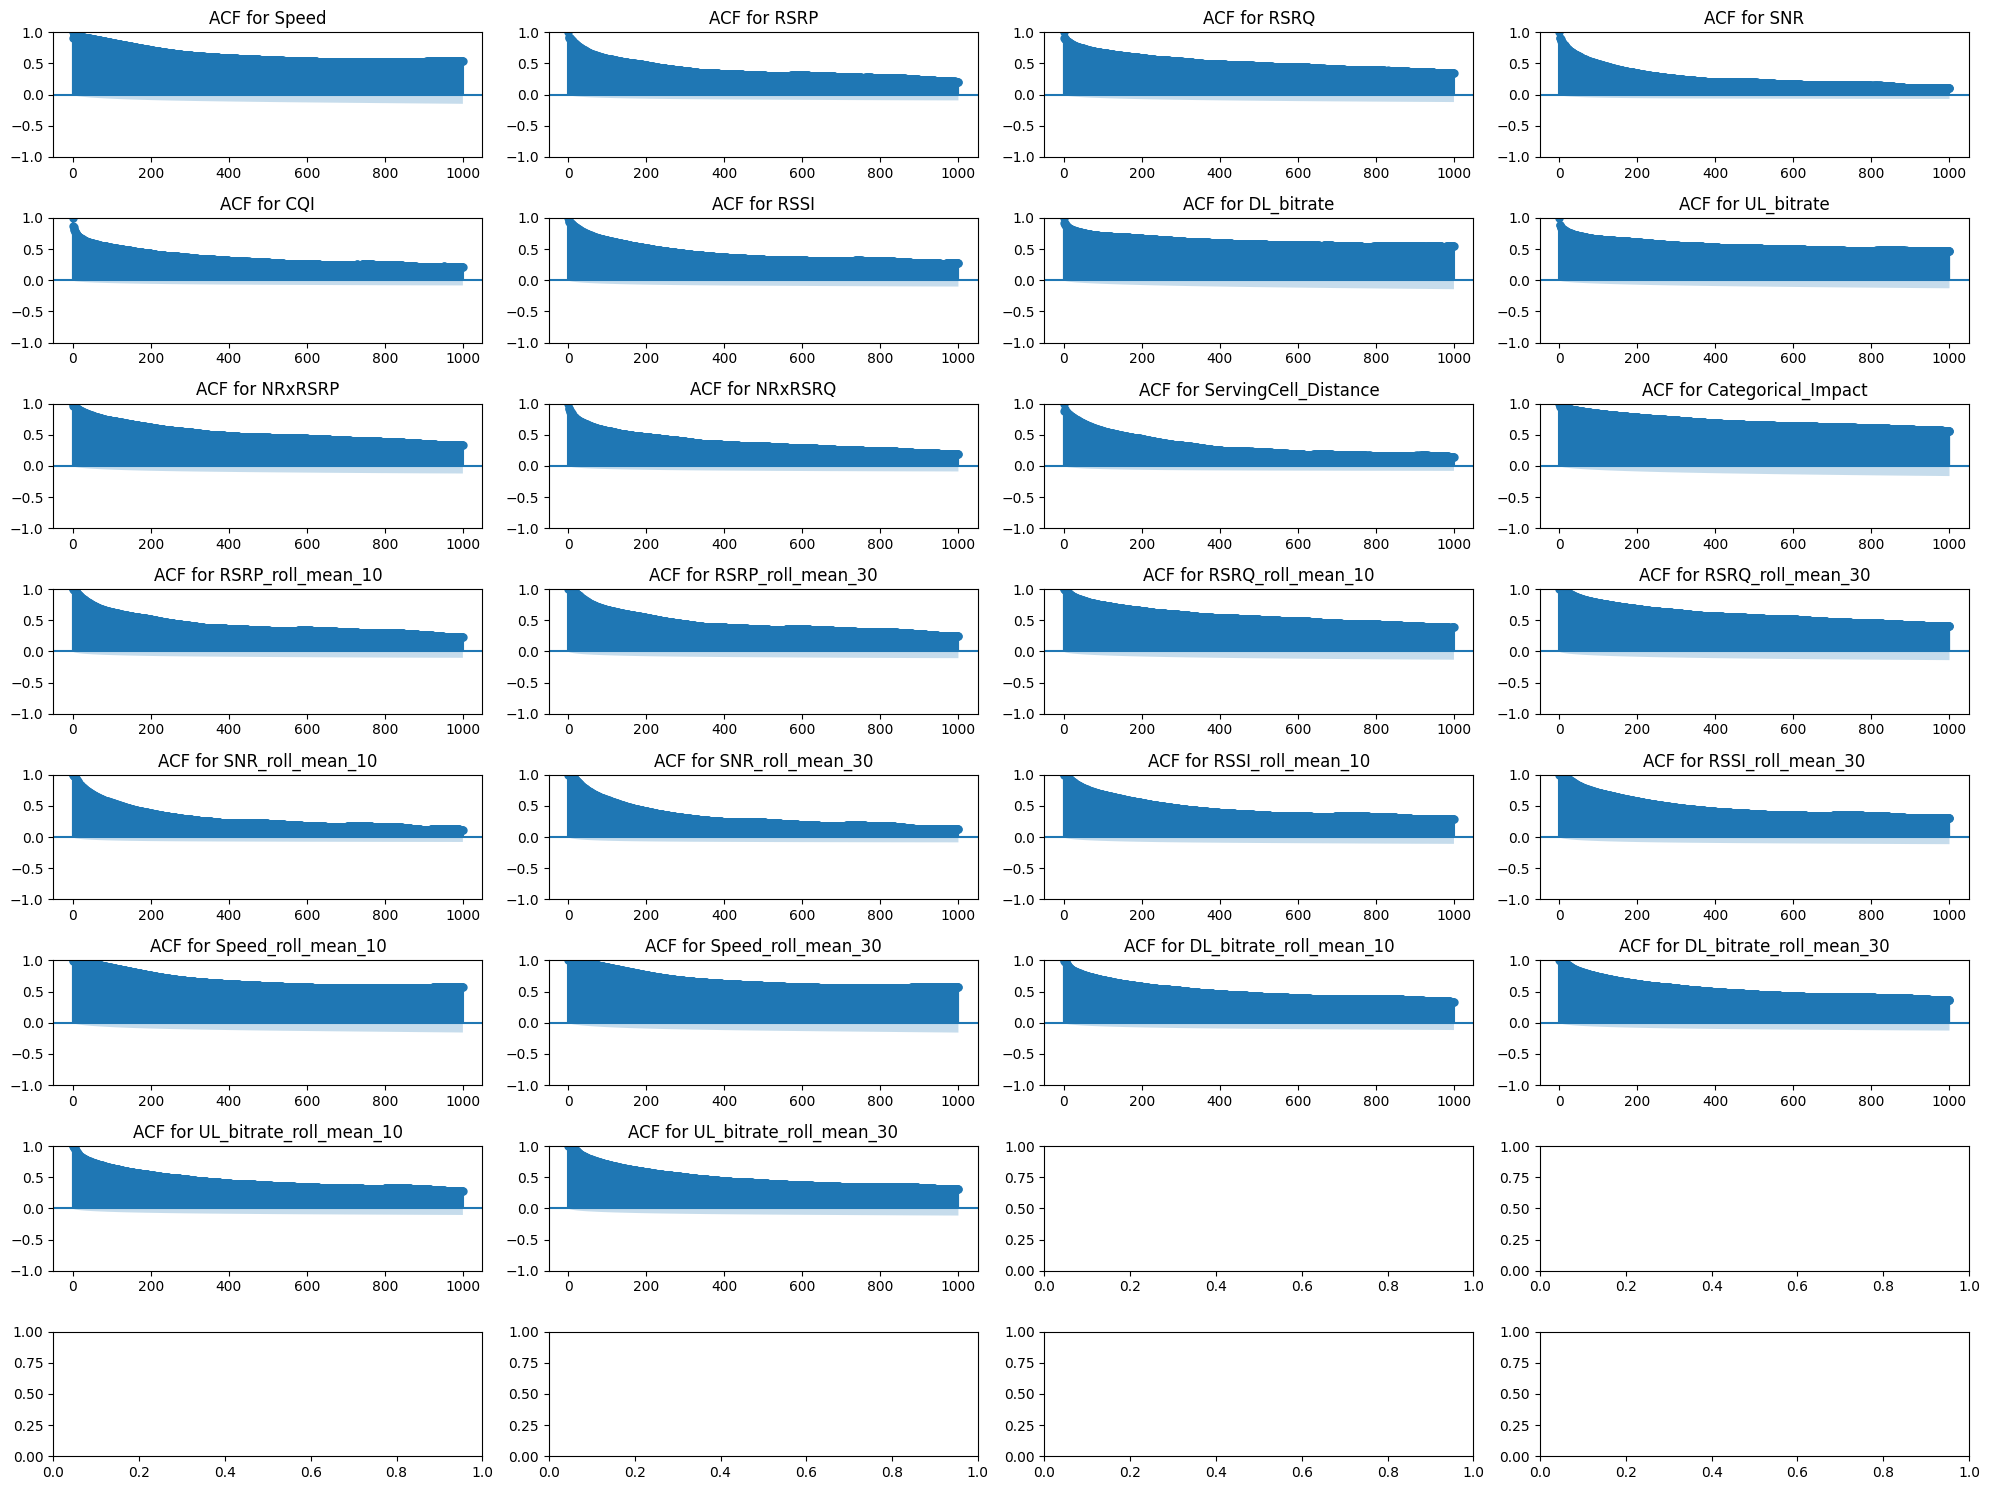

In [9]:
# Define the rolling features names
rolling_feature_names = [f"{f}_roll_mean_{w}" for f in rolling_features for w in rolling_windows]

# Combine them with the rest features
features = features + rolling_feature_names

# Compute and plot the Autocorrelation Function (ACF) for each feature of training set
rows, cols = 8, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, column in enumerate(features):
    row, col = divmod(i, cols)
    sm.graphics.tsa.plot_acf(
        train_df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col]
    )
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()

Then, we apply Grid Search with 5-Cross Validation to determine the best combination of the hyperparameters for the different amount of lagged features based on MAE of Validation Set. We split the training set into the following subsets:

- Training Set: 60% (75% of initial training set)

- Validation Set: 20% (25% of initial training set)

The test set remains 20% as previously.

We also apply Min-Max Normalization since the numeric features are measured in different units.

In [12]:
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd
import xgboost as xgb

# Hyperparameters to check
lag_interval = 60
num_lags_list = [5, 10, 20, 30]
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.05, 0.1, 1]
}
param_combinations = list(product(param_grid["n_estimators"],
                                  param_grid["max_depth"],
                                  param_grid["learning_rate"]))

results_list = []

for num_lags in num_lags_list:
    train_lagged = train_df.copy()
    test_lagged = test_df.copy()

    # Add lagged features for numeric columns on both datasets
    for feature in features:  # features = αριθμητικά + rolling μόνο
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            train_lagged[f"{feature}_lag_{lag}"] = train_lagged[feature].shift(lag)
            test_lagged[f"{feature}_lag_{lag}"] = test_lagged[feature].shift(lag)

    # Drop rows with NaNs
    train_lagged = train_lagged.dropna().reset_index(drop=True)
    test_lagged = test_lagged.dropna().reset_index(drop=True)

    # Split training set into 75%/25% → 60% train, 20% validation
    n = len(train_lagged)
    n_train = int(n * 0.75)

    X_train_raw = train_lagged.drop(columns=["Timestamp", "DL_bitrate"]).iloc[:n_train]
    y_train_raw = train_lagged["DL_bitrate"].iloc[:n_train]

    X_val_raw = train_lagged.drop(columns=["Timestamp", "DL_bitrate"]).iloc[n_train:]
    y_val_raw = train_lagged["DL_bitrate"].iloc[n_train:]

    X_test_raw = test_lagged.drop(columns=["Timestamp", "DL_bitrate"], errors="ignore")
    y_test_raw = test_lagged["DL_bitrate"]

    # Apply MinMaxScaler
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train_raw)
    X_val = scaler_X.transform(X_val_raw)
    X_test = scaler_X.transform(X_test_raw)

    y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()

    # Grid Search
    for n_estimators, max_depth, learning_rate in param_combinations:
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            objective="reg:squarederror",
            random_state=42
        )

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

        mae_val = mean_absolute_error(y_val_true, y_val_pred_denorm)

        results_list.append({
            "num_lags": num_lags,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "MAE_Validation": mae_val
        })

# Find best combination of lags and hyperparameters based on Validation MAE
results_df = pd.DataFrame(results_list)
best_row = results_df.loc[results_df["MAE_Validation"].idxmin()]

print("\n--- Best Configuration Based on Validation MAE ---")
print(f"Num Lags      : {best_row['num_lags']}")
print(f"n_estimators  : {best_row['n_estimators']}")
print(f"max_depth     : {int(best_row['max_depth'])}")
print(f"learning_rate : {best_row['learning_rate']}")
print(f"Validation MAE: {best_row['MAE_Validation']:.2f}")

<ipython-input-12-79379426075e>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_lagged[f"{feature}_lag_{lag}"] = train_lagged[feature].shift(lag)
<ipython-input-12-79379426075e>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_lagged[f"{feature}_lag_{lag}"] = test_lagged[feature].shift(lag)
<ipython-input-12-79379426075e>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

KeyboardInterrupt: 

After the Grid Serch we create the optimal amount of lagged features and add them in both training and test set.

In [17]:
# Keep best amount of lags
best_num_lags = 30
#best_num_lags = int(best_row["num_lags"])

# Add lagged features on both datasets
for feature in features:
    for lag in range(lag_interval, lag_interval * best_num_lags + 1, lag_interval):
        train_df[f"{feature}_lag_{lag}"] = train_df[feature].shift(lag)
        test_df[f"{feature}_lag_{lag}"] = test_df[feature].shift(lag)

# Drop rows with NaNs after lagging
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [18]:
train_df

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,...,Categorical_Impact_lag_1260,Categorical_Impact_lag_1320,Categorical_Impact_lag_1380,Categorical_Impact_lag_1440,Categorical_Impact_lag_1500,Categorical_Impact_lag_1560,Categorical_Impact_lag_1620,Categorical_Impact_lag_1680,Categorical_Impact_lag_1740,Categorical_Impact_lag_1800
0,2017-11-21 15:40:02,3.0,-76.0,-13.0,12.0,8.0,-58.0,7.312553,3.951244,-79.0,...,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.294650,0.758840
1,2017-11-21 15:40:04,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.192294,4.543295,-85.0,...,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.294650,0.758840
2,2017-11-21 15:40:05,3.0,-74.0,-13.0,10.0,8.0,-58.0,8.539346,4.564348,-85.0,...,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.294650,0.758840
3,2017-11-21 15:40:06,3.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.294650,0.758840
4,2017-11-21 15:40:07,4.0,-77.0,-13.0,15.0,11.0,-60.0,7.377759,3.401197,-85.0,...,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.758840,0.294650,0.758840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137119,2018-01-18 15:03:26,0.0,-95.0,-14.0,-5.0,8.0,-88.0,8.826441,4.644391,-98.0,...,0.471460,0.581546,0.443432,0.443432,0.581546,0.443432,0.443432,0.443432,0.581546,0.581546
137120,2018-01-18 15:03:26,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.570669,5.379897,-107.0,...,0.192634,0.443432,0.581546,0.581546,0.443432,0.581546,0.581546,0.581546,0.581546,0.443432
137121,2018-01-18 15:03:27,0.0,-95.0,-14.0,-5.0,8.0,-88.0,9.041211,4.962845,-98.0,...,0.471460,0.581546,0.443432,0.443432,0.443432,0.443432,0.443432,0.443432,0.443432,0.443432
137122,2018-01-18 15:03:28,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.640758,5.549076,-107.0,...,0.192634,0.443432,0.581546,0.581546,0.581546,0.581546,0.581546,0.443432,0.581546,0.581546


## **Model Training**

We train the model by fine tuning it with the best combination of hyperparameters from before. To check if the model is over or under fitting we plot the learning curves for the training, validation and testing set.

[0]	train-rmse:0.29936	train-mae:0.22666	eval-rmse:0.24034	eval-mae:0.21210	test-rmse:0.24243	test-mae:0.19637
[10]	train-rmse:0.18411	train-mae:0.14040	eval-rmse:0.15728	eval-mae:0.13961	test-rmse:0.15764	test-mae:0.12712
[20]	train-rmse:0.11580	train-mae:0.08930	eval-rmse:0.10558	eval-mae:0.09355	test-rmse:0.10728	test-mae:0.08491
[30]	train-rmse:0.07634	train-mae:0.05975	eval-rmse:0.07513	eval-mae:0.06587	test-rmse:0.07942	test-mae:0.06069
[40]	train-rmse:0.05467	train-mae:0.04259	eval-rmse:0.05730	eval-mae:0.04904	test-rmse:0.06474	test-mae:0.04683
[50]	train-rmse:0.04370	train-mae:0.03274	eval-rmse:0.04726	eval-mae:0.03901	test-rmse:0.05741	test-mae:0.03918
[60]	train-rmse:0.03861	train-mae:0.02706	eval-rmse:0.04198	eval-mae:0.03323	test-rmse:0.05374	test-mae:0.03499
[70]	train-rmse:0.03630	train-mae:0.02380	eval-rmse:0.03892	eval-mae:0.02970	test-rmse:0.05180	test-mae:0.03262
[80]	train-rmse:0.03524	train-mae:0.02194	eval-rmse:0.03709	eval-mae:0.02742	test-rmse:0.05068	test-mae:0

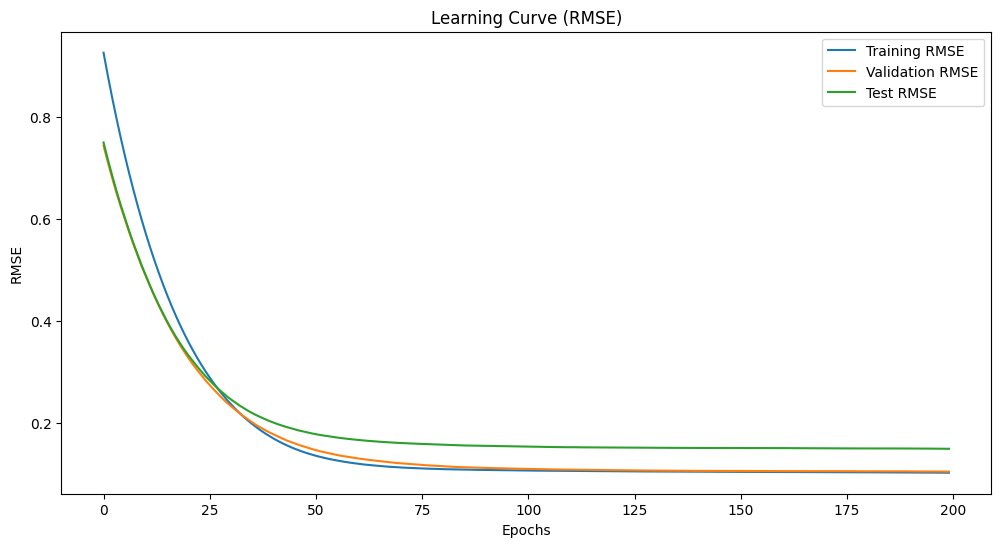

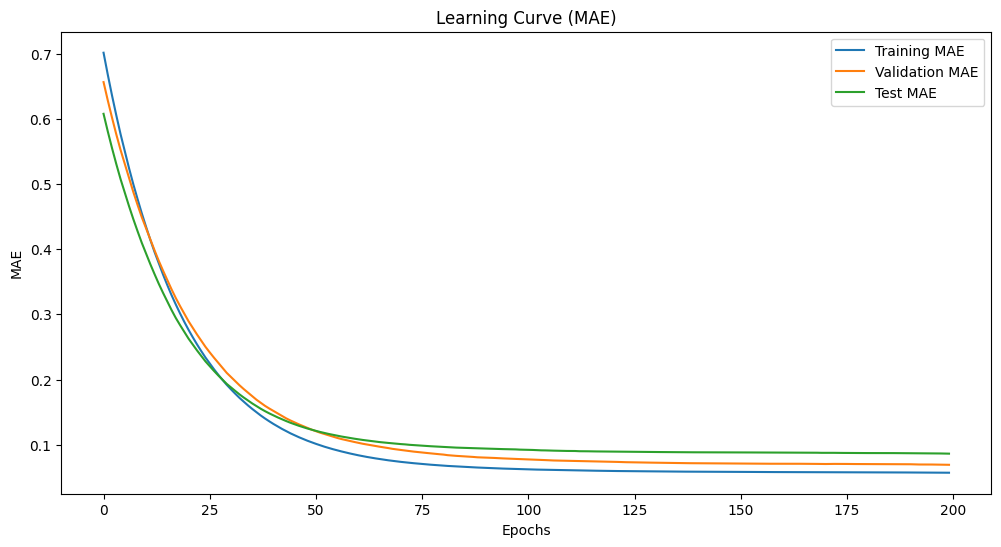

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define model inputs and target (X,y)
X_full = train_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_full_raw = train_df["DL_bitrate"]

# Split into 60-20-20 ratio for train, validation, test
n = len(X_full)
n_train = int(n * 0.75)

X_train_raw = X_full.iloc[:n_train] # 75% of 80% to get 60% for training set
y_train_raw = y_full_raw.iloc[:n_train]
X_val_raw = X_full.iloc[n_train:] # 25% of 80% to get 20% for validation set
y_val_raw = y_full_raw.iloc[n_train:]

# Test set is the rest 20%
X_test_raw = test_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_test_raw = test_df["DL_bitrate"]

# Apply MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()  # Only transform without fit on the other 2 subsets

# XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the best combination of hyperparameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'eval_metric': ['rmse', 'mae']
}

evals = [(dtrain, 'train'), (dval, 'eval'), (dtest, 'test')]
num_round = 200
history = {}

# Train using early stopping
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10,
                verbose_eval=10, evals_result=history)

# Draw learning curves for 200 training epochs
epochs = len(history['train']['rmse'])
std_y = np.std(y_full_raw)

train_rmse = np.array(history['train']['rmse']) * std_y
eval_rmse = np.array(history['eval']['rmse']) * std_y
test_rmse = np.array(history['test']['rmse']) * std_y

train_mae = np.array(history['train']['mae']) * std_y
eval_mae = np.array(history['eval']['mae']) * std_y
test_mae = np.array(history['test']['mae']) * std_y

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_rmse, label="Training RMSE")
plt.plot(range(epochs), eval_rmse, label="Validation RMSE")
plt.plot(range(epochs), test_rmse, label="Test RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_mae, label="Training MAE")
plt.plot(range(epochs), eval_mae, label="Validation MAE")
plt.plot(range(epochs), test_mae, label="Test MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning Curve (MAE)")
plt.legend()
plt.show()

# Make the predictions on all sets
y_train_pred = bst.predict(dtrain)
y_val_pred = bst.predict(dval)
y_test_pred = bst.predict(dtest)

# Reverse the MinMax scaling and log transform of the predictions
y_train_true = np.expm1(scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten())
y_train_pred_denorm = np.expm1(scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten())

y_val_true = np.expm1(scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten())
y_val_pred_denorm = np.expm1(scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten())

y_test_true = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten())
y_test_pred_denorm = np.expm1(scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten())

# Store the reversed true and predicted values for each subset
predictions_df = pd.concat([
    pd.DataFrame({"true": y_train_true, "pred": y_train_pred_denorm, "set": "train"}),
    pd.DataFrame({"true": y_val_true, "pred": y_val_pred_denorm, "set": "val"}),
    pd.DataFrame({"true": y_test_true, "pred": y_test_pred_denorm, "set": "test"})
], ignore_index=True)

## **Model evaluation**

We calculate basic metrics like MAE, RMSE to evaluate the model's performance. Also, for better understanding we calculate the percentages of the error metrics to see how far the predictions are from the mean actual DL_bitrate of the test data.

In [54]:
# Print the final error metrics values for all the subsets
print("-" * 40)
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_true, y_train_pred_denorm)):.2f}")
print(f"Train MAE : {mean_absolute_error(y_train_true, y_train_pred_denorm):.2f}")
print("-" * 40)
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val_true, y_val_pred_denorm)):.2f}")
print(f"Validation MAE : {mean_absolute_error(y_val_true, y_val_pred_denorm):.2f}")
print("-" * 40)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_true, y_test_pred_denorm)):.2f}")
print(f"Test MAE : {mean_absolute_error(y_test_true, y_test_pred_denorm):.2f}")

# Calculate the mean true value of the test set by inverting the log transform and the normalization
test_data = predictions_df[predictions_df["set"] == "test"]
mean_dl_bitrate_actual_value = test_data["true"].mean()

# Print mean value and percentage of MAE for DL_bitrate
test_mae = mean_absolute_error(test_data["true"], test_data["pred"])
print(f"\nMean actual DL_bitrate in test set: {mean_dl_bitrate_actual_value:.2f} Kbps")
print(f"Relative MAE: {(test_mae / mean_dl_bitrate_actual_value) * 100:.2f}%")

----------------------------------------
Train RMSE: 1578.13
Train MAE : 879.56
----------------------------------------
Validation RMSE: 4777.58
Validation MAE : 3062.42
----------------------------------------
Test RMSE: 6967.31
Test MAE : 3028.75

Mean actual DL_bitrate in test set: 11951.01 Kbps
Relative MAE: 25.34%


After the evaluation of the model we plot the first 5000 instances of the actual and the predicted timeseries of the test set to better visualize the forecasting results.

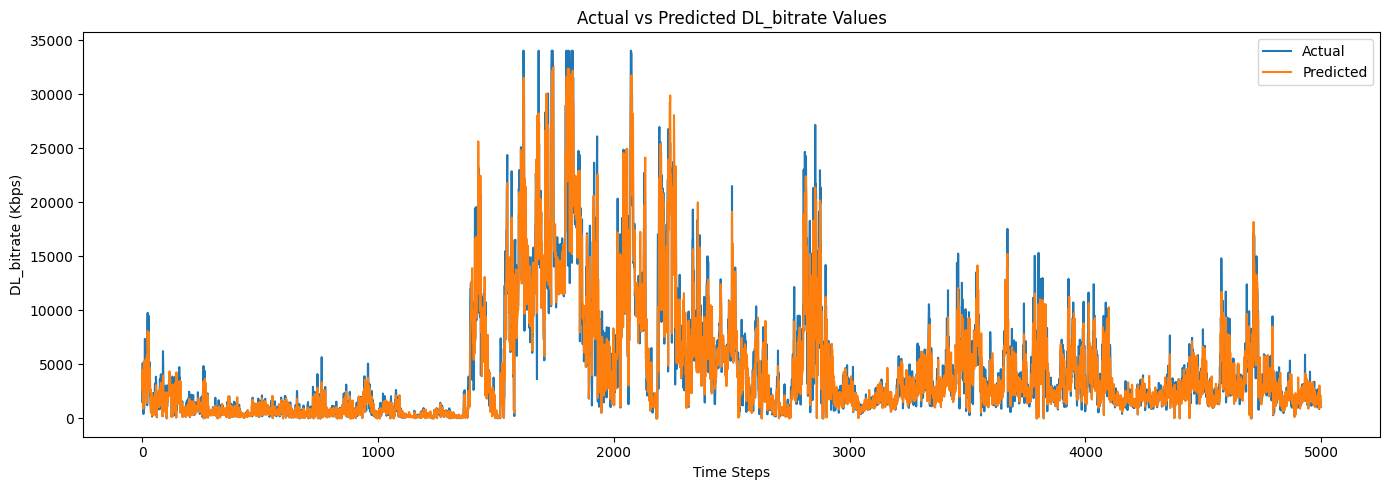

In [37]:
# Plot Timeseries Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 5))
plt.plot(predictions_df["true"].values[:5000], label='Actual')
plt.plot(predictions_df["pred"].values[:5000], label='Predicted')
plt.title("Actual vs Predicted DL_bitrate Values")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate (Kbps)")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
predictions_df[predictions_df["set"] == "test"]

,true,pred,set
137124,14662.0,15281.465820,test
137125,25040.0,20313.792969,test
137126,22345.0,17622.156250,test
137127,15713.0,14416.425781,test
137128,18263.0,16386.468750,test
...,...,...,...
170029,40586.0,30887.804688,test
170030,4496.0,4963.722656,test
170031,49120.0,30887.804688,test
170032,59364.0,32399.500000,test


## **Model explainability**

Finally, we use the SHAP tool to determine which features contribute the most into the final forecasting value. We compute a Waterfall Plot to check the feature contribution in one instance and then we compute Bar Plot and Beeswarm Plot to determine the overall contribution.

100%|===================| 32773/32910 [01:36<00:00]       

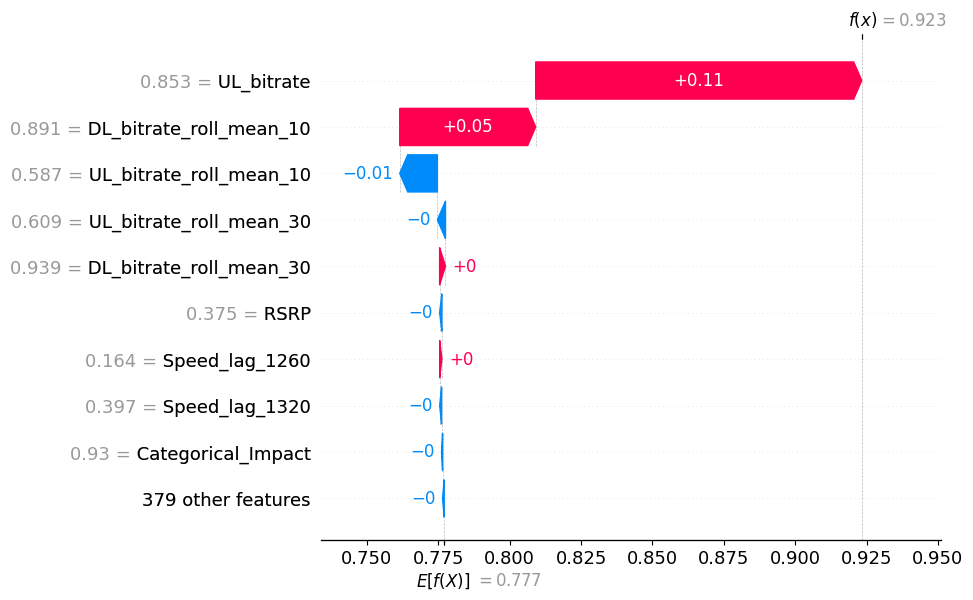

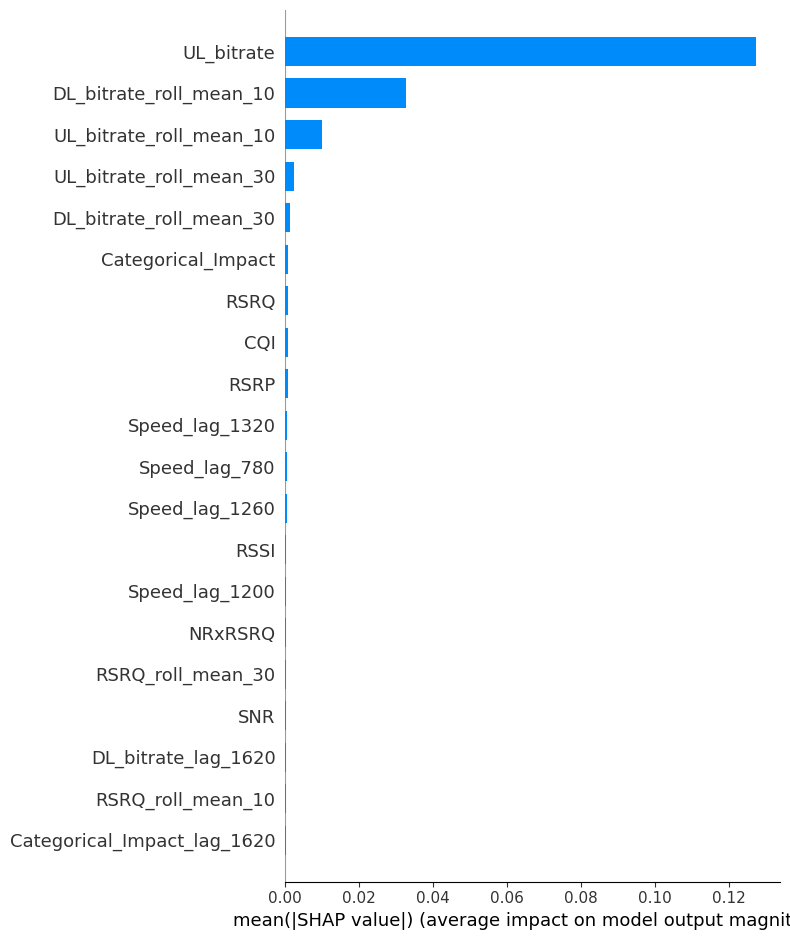

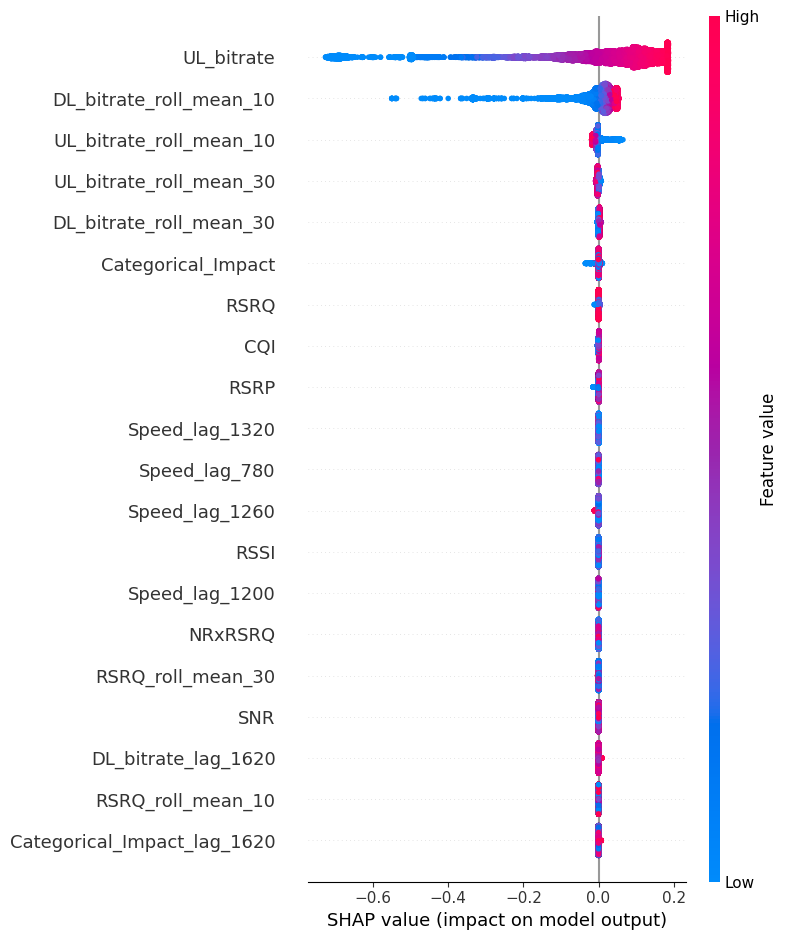

In [45]:
# Create DataFrame with the same feature names used in training
X_test_df = pd.DataFrame(X_test, columns=X_test_raw.columns)

# Initialize SHAP Explainer for xgboost model
explainer = shap.Explainer(bst, X_test_df)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# SHAP Plots
# Waterfall plot for the first instance
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                      base_values=explainer.expected_value,
                                      data=X_test_df.iloc[0],
                                      feature_names=X_test_df.columns))

# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Beeswarm plot
shap.summary_plot(shap_values, X_test_df)

In the end, we visualize how the performance of the model is affected by removing gradually more and more features based on their contribution.

 99%|===================| 32703/32910 [01:45<00:00]       

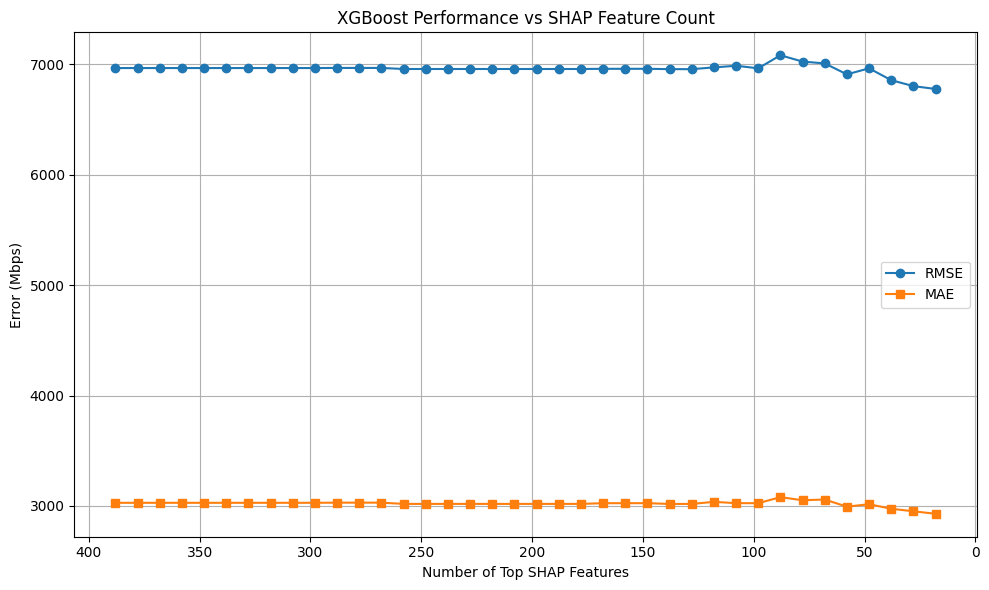

In [48]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

feature_names = list(X_full.columns)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP Explainer and calculation of shap_values
explainer = shap.Explainer(bst, X_test_df)
shap_values = explainer(X_test_df)

# Feature importance ranking
shap_importance = np.abs(shap_values.values).mean(axis=0)
ordered_features = np.array(feature_names)[np.argsort(-shap_importance)].tolist()

X_trainval_df = pd.DataFrame(X_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_scaled_full = y_scaled
y_test_scaled_full = y_test

# Retraining with top-N SHAP features
results = []
step = 10

for num_feats in range(len(ordered_features), step - 1, -step):
    top_features = ordered_features[:num_feats]

    # Feature selection
    X_subset = X_trainval_df[top_features]
    X_test_subset = X_test_df[top_features]

    # Train/Val split 75/25 → 60/20
    X_train, X_val, y_train, y_val = train_test_split(
        X_subset, y_scaled_full, test_size=0.25, shuffle=False, random_state=42
    )

    # Train model
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions and reversion of scaling/log1p
    y_pred = model.predict(X_test_subset)
    y_pred_denorm = np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten())
    y_test_denorm = np.expm1(scaler_y.inverse_transform(y_test_scaled_full.reshape(-1, 1)).flatten())

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

    results.append({
        "Num_Features": num_feats,
        "RMSE": rmse,
        "MAE": mae
    })

# Visualize results
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df["Num_Features"], results_df["RMSE"], marker='o', label="RMSE")
plt.plot(results_df["Num_Features"], results_df["MAE"], marker='s', label="MAE")
plt.xlabel("Number of Top SHAP Features")
plt.ylabel("Error (Mbps)")
plt.title("XGBoost Performance vs SHAP Feature Count")
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

We plot the evolution of relative MAE and observe that its values are strongly between the interval 25.1% ± 0.7%. Therefore, there is no significant drop by removing the features.

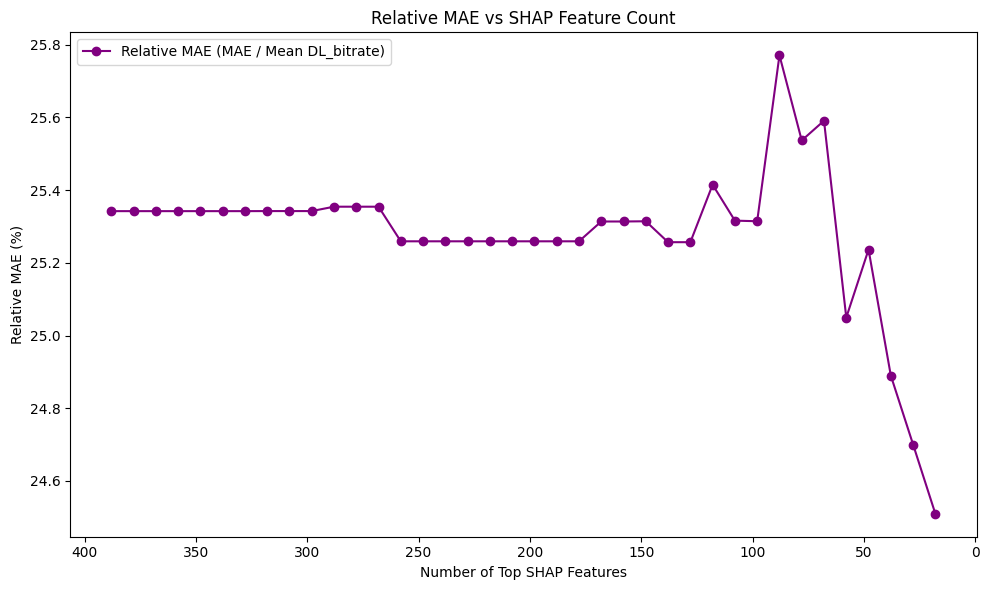

In [55]:
mean_bitrate = np.mean(y_test_denorm)

plt.figure(figsize=(10, 6))
plt.plot(results_df["Num_Features"], (results_df["MAE"]/mean_bitrate)*100, marker='o', color='purple', label="Relative MAE (MAE / Mean DL_bitrate)")
plt.xlabel("Number of Top SHAP Features")
plt.ylabel("Relative MAE (%)")
plt.title("Relative MAE vs SHAP Feature Count")
plt.legend()
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()